In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json

In [2]:
test_answer_accs = np.load("data/MATH_aug/test_answer_types5.npy")==0

hard_idxs = np.where(test_answer_accs.sum(axis=-1)==0)[0]
easy_idxs = np.where(test_answer_accs.sum(axis=-1)==4)[0]

In [3]:
test_accs_all = []
ckpts = ["1666", "3332", "4998", "6664", "8330", "9996", "11662", "13328", "14994", "16660"]
for ckpt in ckpts:
    test_accs = (np.load("ckpts/math_aug3_total20000_epochs20/checkpoint-"+ckpt+ "/test_answer_types5_seed2.npy")==0)
    print(test_accs[easy_idxs].mean())
    test_accs_all.append(test_accs[easy_idxs].mean())

test_accs_all = np.array(test_accs_all)

0.19795081967213116
0.3094262295081967
0.364344262295082
0.39385245901639343
0.4336065573770492
0.460655737704918
0.4663934426229508
0.5077868852459017
0.5131147540983606
0.5397540983606557


In [2]:
with open('data/MATH_aug/AugMATH_part1.jsonl', 'r') as json_file:
    json_list = list(json_file)

with open('data/MATH_aug/AugMATH_part2.jsonl', 'r') as json_file:
    json_list += list(json_file)

train_questions = []
train_answers = []
for json_str in json_list:
    result = json.loads(json_str)
    train_questions.append(result["query"])
    train_answers.append(result["response"])
    
train_questions = np.array(train_questions)
train_answers = np.array(train_answers)

In [3]:
subsample_idxs = np.load("ckpts/math_aug3_total20000_epochs20/subsample_idxs.npy")

In [6]:
num_memorized_all = []
num_correct_different_all = []
num_incorrect_all = []

ckpts = ["1666", "3332", "4998", "6664", "8330", "9996", "11662", "13328", "14994", "16660"]
# ckpts = ["3332", "6664", "9996", "13328", "16660"]

for ckpt in ckpts:
    train_correct = (np.load("ckpts/math_aug3_total20000_epochs20/checkpoint-"+ckpt+ "/train_aug_subsample_answer_types5_seed2.npy")==0)
    train_samples = (np.load("ckpts/math_aug3_total20000_epochs20/checkpoint-"+ckpt+ "/train_aug_subsample_answers5_seed2.npy"))

    num_memorized_ckpt = []
    num_correct_different_ckpt = []
    num_incorrect_ckpt = []

    for input_idx in range(len(train_correct)):
        num_memorized = 0
        num_correct_different = 0
        num_incorrect = 0
        for sample_idx in range(5):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    num_memorized+=1
                else:
                    num_correct_different+=1
            else:
                num_incorrect+=1 
        num_memorized_ckpt.append(num_memorized)
        num_correct_different_ckpt.append(num_correct_different)
        num_incorrect_ckpt.append(num_incorrect)
    
    num_memorized_all.append(num_memorized_ckpt)
    num_correct_different_all.append(num_correct_different_ckpt)
    num_incorrect_all.append(num_incorrect_ckpt)
    
num_memorized_all = np.array(num_memorized_all)
num_correct_different_all = np.array(num_correct_different_all)
num_incorrect_all = np.array(num_incorrect_all)

In [75]:
cummulative_num_correct_different = []
for i in range(10):
    cummulative_num_correct_different.append((num_correct_different_all[:i+1].sum(axis=0)>0).sum())

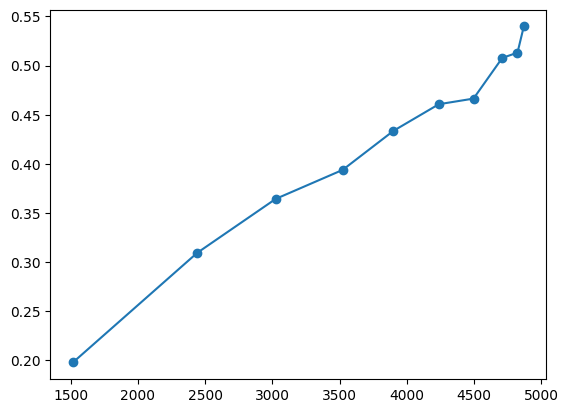

In [76]:
plt.plot(cummulative_num_correct_different, test_accs_all, "o-")

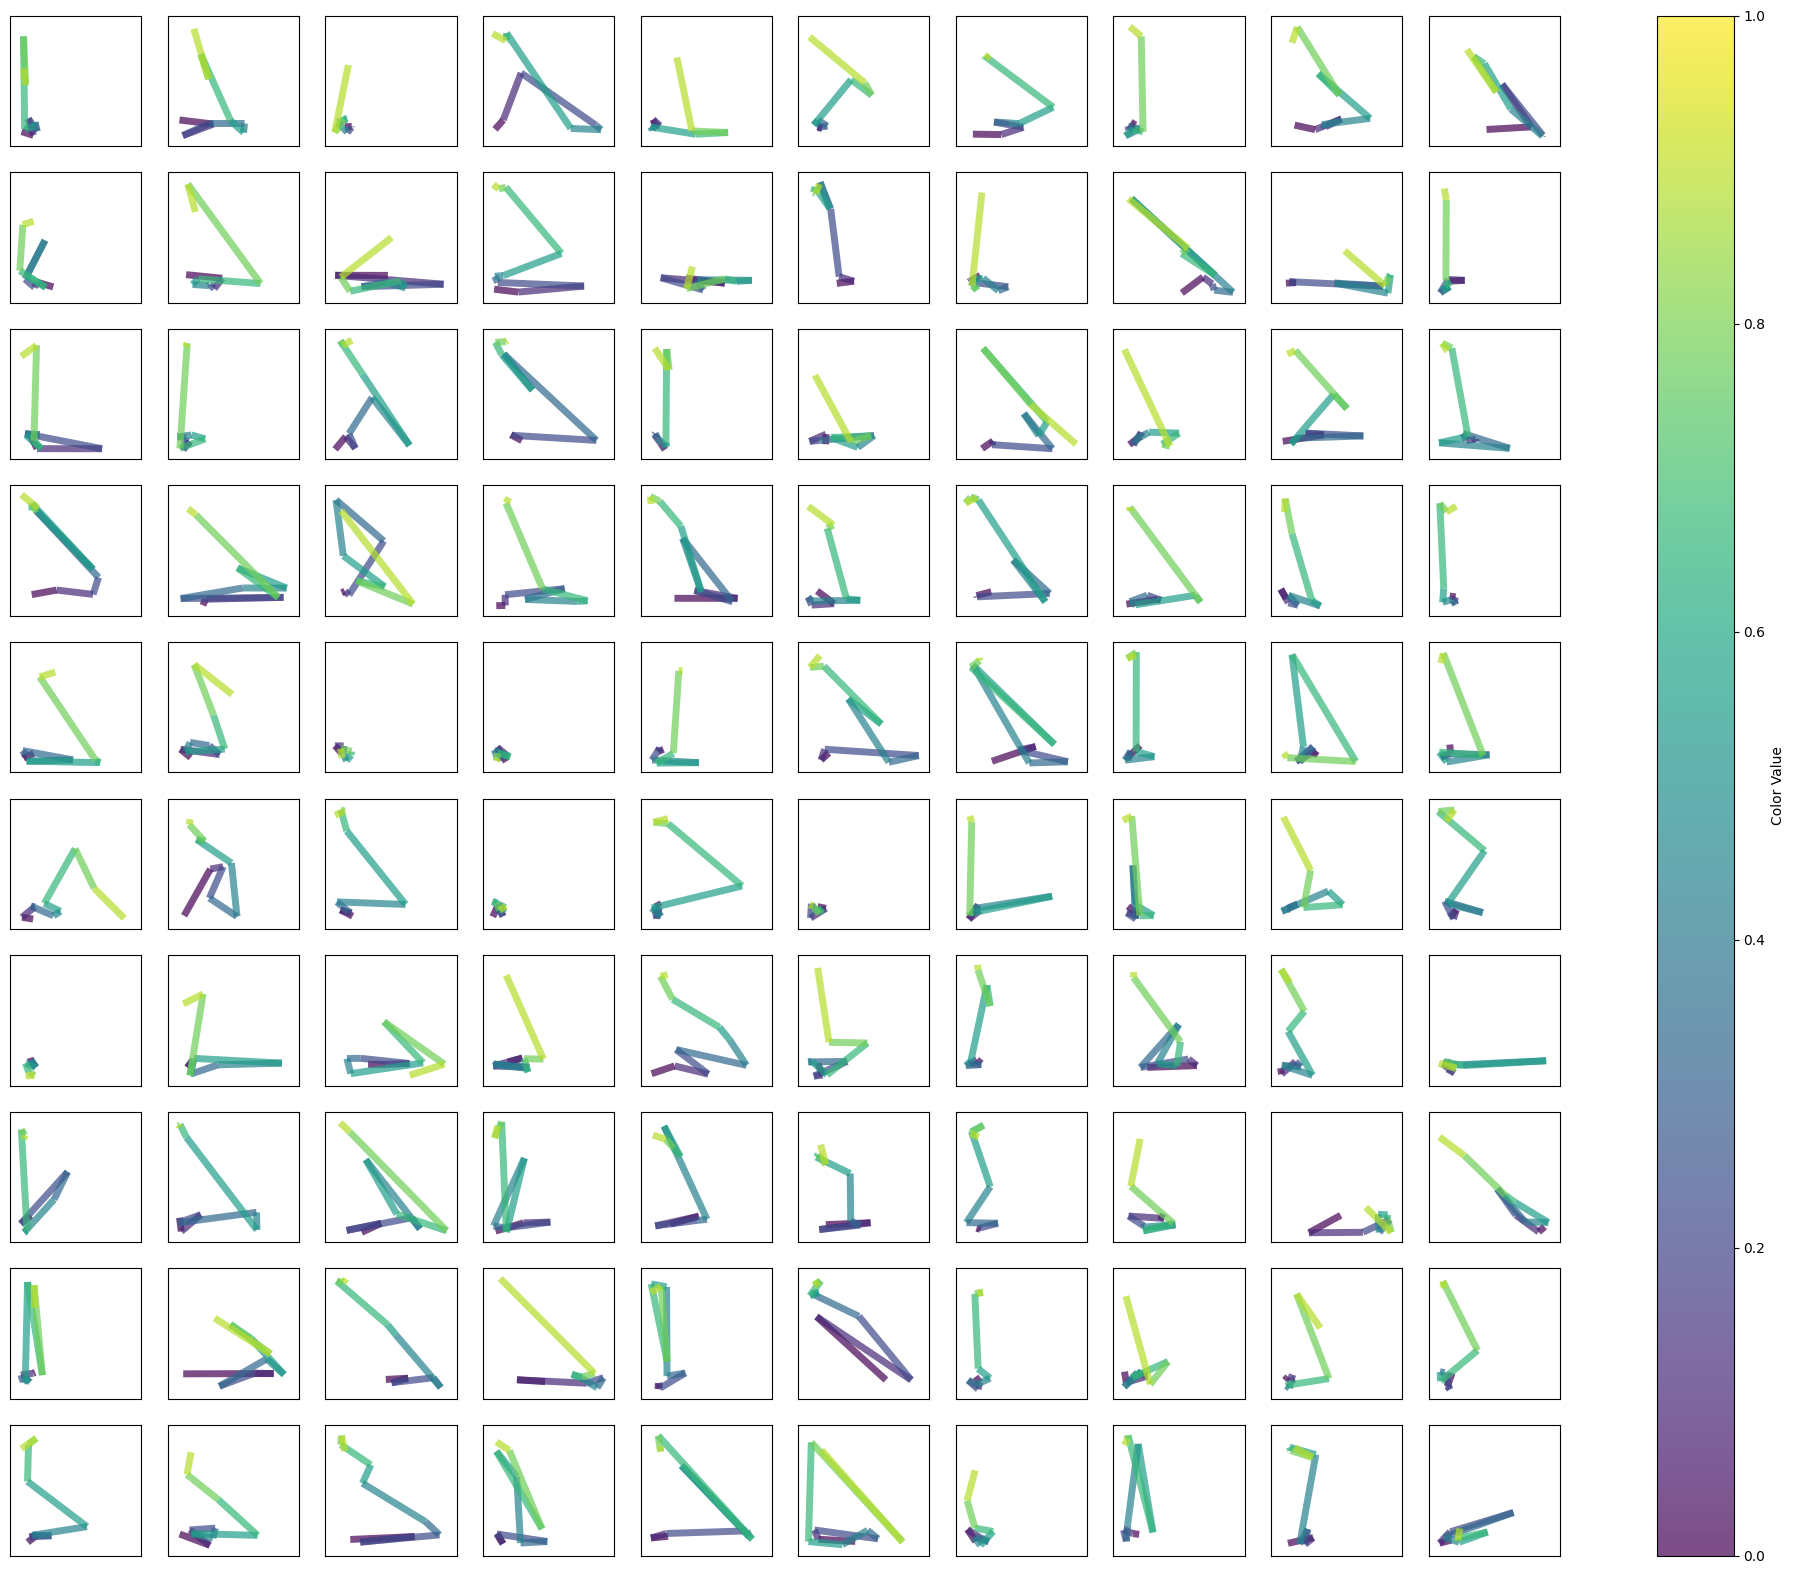

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap


# Create a gradient color map
cmap = plt.get_cmap('viridis')
# Create the plot
fig, ax = plt.subplots(10, 10, figsize=(25, 20))

# Create an array of values to use for coloring each segment
color_values = np.linspace(0, 1, 10)


i = 4


for i in range(100):
    x = num_correct_different_all[:, i]+np.random.uniform(-0.5, 0.5, 10)
    y = num_memorized_all[:, i]+np.random.uniform(-0.5, 0.5, 10)
    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection from the segments
    lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(0, 1), alpha=0.7)
    lc.set_array(color_values)
    lc.set_linewidth(5)


    ax[i//10][i%10].add_collection(lc)
    ax[i//10][i%10].autoscale()
    ax[i//10][i%10].set_xlim(-1, 6)
    ax[i//10][i%10].set_ylim(-1, 6)
    ax[i//10][i%10].set_yticks([])
    ax[i//10][i%10].set_xticks([])

# # Plot markers at the start of each segment
# ax.plot(x, y, 'o', color='black')

# Add a colorbar
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Color Value')

# Display the plot
plt.show()

In [20]:
group_all = []

for j in range(5):
    groups = []
    for i in range(5000):
        if num_memorized_all[j][i]>2:
            groups.append(2)
        elif num_correct_different_all[j][i]>2:
            groups.append(1)
        else:
            groups.append(0)
    group_all.append(groups)
    
group_all = np.array(group_all)

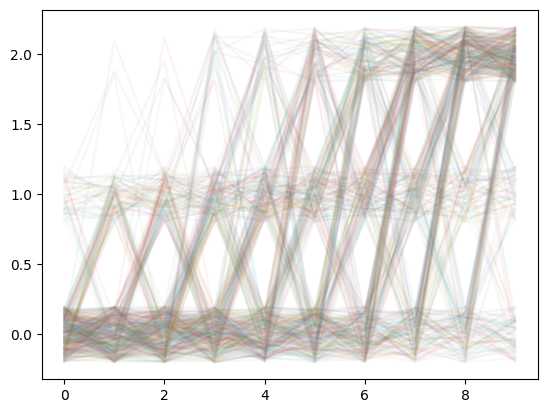

In [91]:
for i in range(500):
    plt.plot(group_all[:, i]+np.random.uniform(-0.2, 0.2, 10), alpha=0.05)

In [16]:
import pandas as pd
import plotly.graph_objects as go

ckpt_idx = 5

num_skip = 2

label_list = [ 'incorrect1', 'unmemorized1', 'memorized1','incorrect2', 'unmemorized2', 'memorized2',]
# cat: 0, dog: 1, domesticated: 2, female: 3, male: 4, wild: 5
source = [0, 0, 0, 1, 1, 1, 2, 2, 2]


target = [3, 4, 5, 3, 4, 5,3, 4, 5,]
count = [((group_all[ckpt_idx]==0)*(group_all[ckpt_idx+num_skip]==0)).sum(),
         ((group_all[ckpt_idx]==0)*(group_all[ckpt_idx+num_skip]==1)).sum(),
         ((group_all[ckpt_idx]==0)*(group_all[ckpt_idx+num_skip]==2)).sum(),
         ((group_all[ckpt_idx]==1)*(group_all[ckpt_idx+num_skip]==0)).sum(),
         ((group_all[ckpt_idx]==1)*(group_all[ckpt_idx+num_skip]==1)).sum(),
         ((group_all[ckpt_idx]==1)*(group_all[ckpt_idx+num_skip]==2)).sum(),
         ((group_all[ckpt_idx]==2)*(group_all[ckpt_idx+num_skip]==0)).sum(),
         ((group_all[ckpt_idx]==2)*(group_all[ckpt_idx+num_skip]==1)).sum(),
         ((group_all[ckpt_idx]==2)*(group_all[ckpt_idx+num_skip]==2)).sum(),]

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])
fig.show()

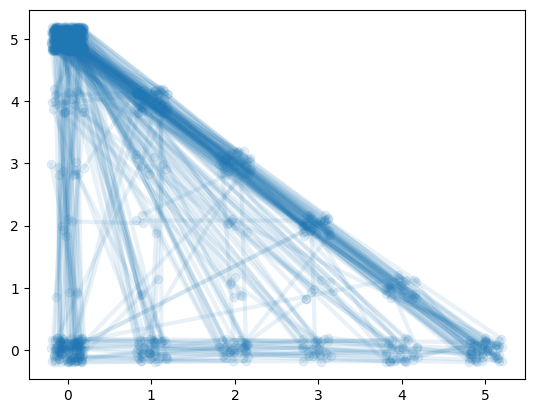

In [41]:
j=3
for i in range(500):
    plt.plot(num_correct_different_all[j:j+2, i]+np.random.uniform(-0.2, 0.2, 2), num_memorized_all[j:j+2, i]+np.random.uniform(-0.2, 0.2, 2), "o-", alpha=0.1, c = "C0", linewidth=3)

In [47]:
import os
from PIL import Image
import matplotlib.cm as cm

# Step 1: Create and save frames with interpolation
frames = []

random_x = np.random.uniform(-0.5, 0.5, (10, 200))
random_y = np.random.uniform(-0.5, 0.5, (10, 200))


# for i in range(3):  # For the first 9 frames
#     fig, ax = plt.subplots()
#     ax.scatter(num_correct_different_all[0, :200] + random_x[0], 
#                num_memorized_all[0, :200] + random_y[0], 
#                alpha=0.5)
#     ax.set_xlim(-0.5, 5.5)
#     ax.set_ylim(-0.5, 5.5)
#     plt.title(f"Frame {i}")
#     plt.savefig(f"frames/frame_{i}.png")
#     frames.append(f"frames/frame_{i}.png")
#     plt.close(fig)
colors = cm.rainbow(np.linspace(0, 1, len(random_y[0])))

for i in range(1, 5):  # For the rest of the frames
    for j in range(10):  # Create 9 interpolated frames between each pair of frames
        alpha = j / 10.0
        fig, ax = plt.subplots()
        interpolated_x = (1 - alpha) * (num_correct_different_all[i - 1, :200]+random_x[i-1]) + alpha * (num_correct_different_all[i, :200] +random_x[i])
        interpolated_y = (1 - alpha) * (num_memorized_all[i - 1, :200]+random_y[i-1]) + alpha * (num_memorized_all[i, :200]+random_y[i])
        for k in range(len(interpolated_x)):
            ax.scatter([interpolated_x[k]], [interpolated_y[k]], alpha=0.5 , color=colors[k])
        ax.set_xlim(-0.5, 5.5)
        ax.set_ylim(-0.5, 5.5)
        plt.title(f"Frame {i*10 + j}")
        plt.savefig(f"frames/frame_{i*10 + j}.png")
        frames.append(f"frames/frame_{i*10 + j}.png")
        plt.close(fig)

# Step 2: Combine images into a GIF
images = [Image.open(frame) for frame in frames]
images[0].save('animated_plot.gif', save_all=True, append_images=images[1:], duration=400, loop=0)

In [8]:
num_correct_different_all.shape

(10, 5000)

In [25]:
num_correct_different_all.shape

(10, 5000)

(array([[1500.,   30.,   20.,   32.,   41.,  300.],
        [ 546.,   33.,   43.,   40.,  152.,    0.],
        [ 395.,   51.,   42.,  139.,    0.,    0.],
        [ 357.,   61.,  148.,    0.,    0.,    0.],
        [ 316.,  159.,    0.,    0.,    0.,    0.],
        [ 595.,    0.,    0.,    0.,    0.,    0.]]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <matplotlib.collections.QuadMesh at 0x7f37961337f0>)

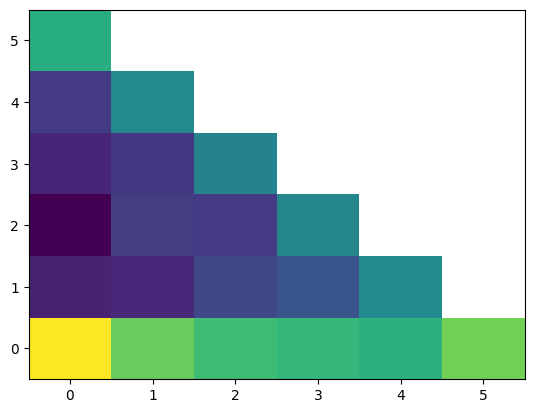

In [15]:
# x axis num memorized
# y axis num correct different
import matplotlib.colors as mcolors
i=-5
plt.hist2d(num_correct_different_all[i], num_memorized_all[i], norm=mcolors.LogNorm(), bins = [np.array([0, 1, 2, 3, 4, 5, 6])-0.5, np.array([0, 1, 2, 3, 4, 5, 6])-0.5,])


(array([3480.,    0.,  485.,    0.,  309.,    0.,  233.,    0.,  199.,
         294.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

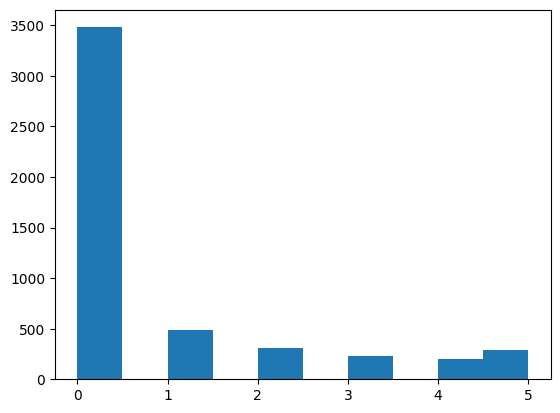

In [10]:
plt.hist(num_correct_different_all[-1])

(array([   8.,   42.,   88.,  208.,  278.,  487.,  611.,  812., 1087.,
        1379.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

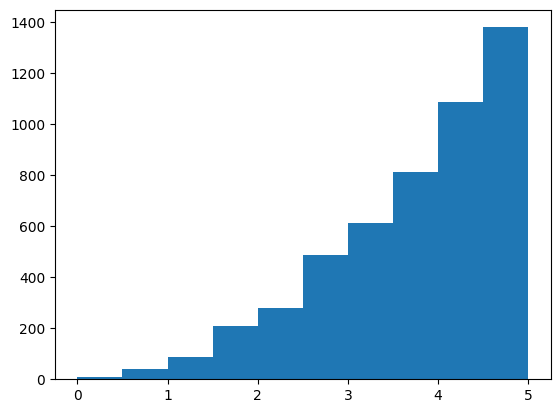

In [38]:
plt.hist((num_memorized_all+num_incorrect_all).mean(axis=0))

In [42]:
((num_memorized_all+num_incorrect_all).mean(axis=0)>4).sum()

2252

In [43]:
len(num_incorrect_all.mean(axis=0))

5000

In [22]:
(num_memorized_all/5).mean(axis=-1)

array([3.2000e-04, 4.4000e-03, 1.6520e-02, 3.7720e-02, 8.2400e-02,
       1.4980e-01, 2.6444e-01, 4.0892e-01, 5.8080e-01, 7.0856e-01])

In [23]:
(num_correct_different_all/5).mean(axis=-1)

array([0.12596, 0.19952, 0.24112, 0.30168, 0.33484, 0.34564, 0.344  ,
       0.30508, 0.22524, 0.16272])

In [24]:
(num_incorrect_all/5).mean(axis=-1)

array([0.87372, 0.79608, 0.74236, 0.6606 , 0.58276, 0.50456, 0.39156,
       0.286  , 0.19396, 0.12872])

In [48]:
train_correct.shape

(5000, 5)

In [61]:
train_correct.shape

(20000, 4)

In [4]:
num_memorized_all = []
num_correct_different_all = []
num_incorrect_all = []

for ckpt in ["3332", "6664", "9996", "13328"]:
    train_correct = (np.load(f"ckpts/math_aug3_total20000_epochs20/checkpoint-{ckpt}/train_aug_answer_types4_seed2.npy")==0)
    train_samples = (np.load(f"ckpts/math_aug3_total20000_epochs20/checkpoint-{ckpt}/train_aug_answers4_seed2.npy"))


    num_memorized_ckpt = []
    num_correct_different_ckpt = []
    num_incorrect_ckpt = []

    for input_idx in range(len(train_correct)):
        num_memorized = 0
        num_correct_different = 0
        num_incorrect = 0
        for sample_idx in range(4):
            correct = train_correct[input_idx, sample_idx]
            if correct:
                if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                    num_memorized+=1
                else:
                    num_correct_different+=1
            else:
                num_incorrect+=1
        num_memorized_ckpt.append(num_memorized)
        num_correct_different_ckpt.append(num_correct_different)
        num_incorrect_ckpt.append(num_incorrect)
    
    num_memorized_all.append(num_memorized_ckpt)
    num_correct_different_all.append(num_correct_different_ckpt)
    num_incorrect_all.append(num_incorrect_ckpt)

train_correct = []
train_samples = []
for seed in ["0", "1", "2", "3", ]:

    train_correct_seed = (np.load(f"ckpts/math_aug3_total20000_epochs20/train_aug_answer_types1_seed{seed}.npy")==0)
    train_samples_seed = (np.load(f"ckpts/math_aug3_total20000_epochs20/train_aug_answers1_seed{seed}.npy"))
    train_correct.append(train_correct_seed)
    train_samples.append(train_samples_seed)

train_correct = np.swapaxes(train_correct, 1, 0,).squeeze()
train_samples = np.swapaxes(train_samples, 1, 0,).squeeze()


num_memorized_ckpt = []
num_correct_different_ckpt = []
num_incorrect_ckpt = []

for input_idx in range(len(train_correct)):
    num_memorized = 0
    num_correct_different = 0
    num_incorrect = 0
    for sample_idx in range(4):
        correct = train_correct[input_idx, sample_idx]
        if correct:
            if train_samples[input_idx][sample_idx].strip() == train_answers[subsample_idxs[input_idx]].strip():
                num_memorized+=1
            else:
                num_correct_different+=1
        else:
            num_incorrect+=1
    num_memorized_ckpt.append(num_memorized)
    num_correct_different_ckpt.append(num_correct_different)
    num_incorrect_ckpt.append(num_incorrect)

num_memorized_all.append(num_memorized_ckpt)
num_correct_different_all.append(num_correct_different_ckpt)
num_incorrect_all.append(num_incorrect_ckpt)

num_memorized_all = np.array(num_memorized_all)
num_correct_different_all = np.array(num_correct_different_all)
num_incorrect_all = np.array(num_incorrect_all)

In [7]:
(num_correct_different_all.max(axis=0)==0).sum()

2646

In [8]:
np.save("ckpts/math_aug3_total20000_epochs20/subsample_idxs_max_unmemorized==0.npy",subsample_idxs[np.where(num_correct_different_all.max(axis=0)==0)[0]])

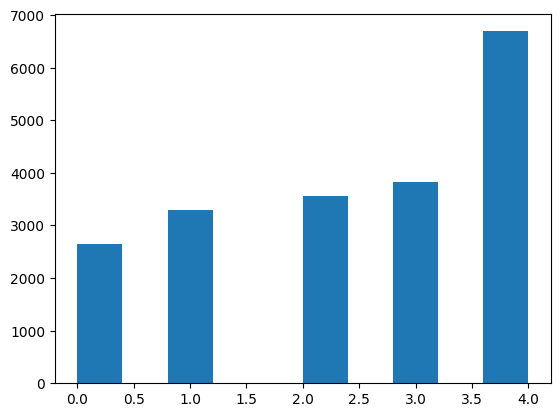

In [13]:
plt.hist(num_correct_different_all.max(axis=0))

plt.savefig("delete.png")

In [34]:
np.save("ckpts/math_aug3_total20000_epochs20/subsample_idxs_max_unmemorized>=3.npy",subsample_idxs[np.where(num_correct_different_all.max(axis=0) >= 3)[0]][:10000])

In [35]:
np.save("ckpts/math_aug3_total20000_epochs20/subsample_idxs_max_unmemorized<=3.npy",subsample_idxs[np.where(num_correct_different_all.max(axis=0) <= 3)[0]][:10000])

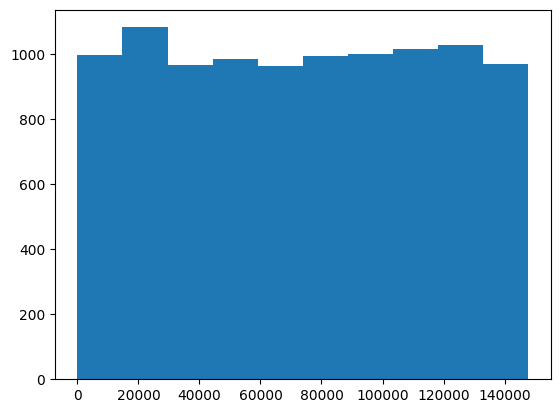

In [36]:
plt.hist(np.load("ckpts/math_aug3_total20000_epochs20/subsample_idxs_max_unmemorized<=3.npy"))
plt.savefig("delete.png")

In [32]:
len(np.where(num_correct_different_all.max(axis=0) >= 3)[0])

10512

In [33]:
len(np.where(num_correct_different_all.max(axis=0) <= 3)[0])

13309

In [ ]:
np.save("ckpts/math_aug3_total20000_epochs20/unmemorized>1_subsample_idxs.npy",subsample_idxs[np.where(num_correct_different_all.max(axis=0) > 1)[0]])

In [20]:
len(subsample_idxs)

20000

In [17]:
np.save("ckpts/math_aug3_total20000_epochs20/memorized_subsample_idxs.npy", subsample_idxs)

In [11]:
(num_correct_different_all.sum(axis=0)>0).sum()

17354

In [64]:
len(subsample_idxs)

17354

In [65]:
np.save("ckpts/math_aug3_total20000_epochs20/unmemorized_subsample_idxs.npy", subsample_idxs)

In [66]:
subsample_idxs = np.random.choice(np.arange(0, len(train_questions), 1), 17354, replace=False)

In [67]:
np.save("ckpts/math_aug3_total20000_epochs20/rand_subsample_idxs.npy", subsample_idxs)

(array([6657., 7912., 3984., 1287.,  160.,    0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

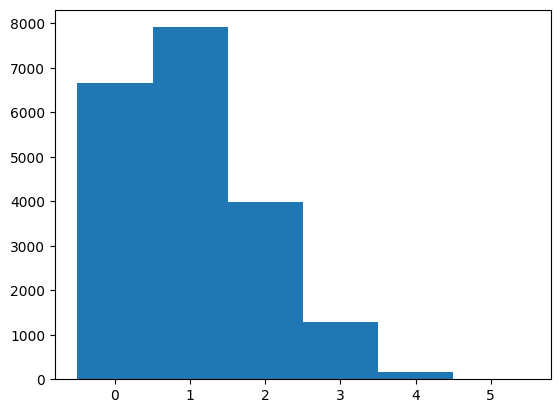

In [33]:
plt.hist(num_correct_different_all.mean(axis=0), bins = np.array([0, 1, 2, 3, 4, 5, 6])-0.5)

In [56]:
np.load(f"ckpts/math_aug3_total20000_epochs20/train_aug_subsample_answer_types1_seed{1}.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'ckpts/math_aug3_total20000_epochs20/train_aug_subsample_answer_types1_seed1.npy'